<a href="https://colab.research.google.com/github/BuddGao/DL-Competition/blob/main/competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip "drive/MyDrive/DL_Project/Train.zip" -d  "drive/MyDrive/DL_Project/"

In [2]:
#!unzip "drive/MyDrive/DL_Project/Val Blind.zip" -d  "drive/MyDrive/DL_Project/"
!/opt/bin/nvidia-smi

Sat Mar  5 21:02:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## preprocess data
## create custom data class
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import KFold
import os
import torch
import pandas as pd
from skimage import io, transform

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from PIL import Image
import glob

class CovidDataset(Dataset):
    """Covid CT dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        ## you can apply custom transformation on the image for data augmentation
        self.transform = transform

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.label_data.iloc[idx, 0])
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        p = self.label_data.iloc[idx, 1]
        subject_num = self.label_data.iloc[idx, 2]
        sample = {'image': image, 'percentage': p, 'subject': subject_num, 'img_name':img_name}

        # should be only applied on image, not percentage or subject #
        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class CovidTestDataset(Dataset):
    """Covid CT TEST dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.image_list = []
        for filename in glob.glob(self.root_dir+"/*.png"): #assuming png
          self.image_list.append(filename)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_list[idx]
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        sample = {'image': image, 'img_name':img_name}

        return sample

In [5]:
import torchvision
covid_dataset_train_val = CovidDataset(csv_file='drive/MyDrive/DL_Project/Train.csv',
                                    root_dir='drive/MyDrive/DL_Project/Train'
                                    #, transform = transforms.Compose([
                                    #           Rescale(256),
                                    #           RandomCrop(224),
                                    #           ToTensor()
                                    #       ])
                                    )

covid_dataset_test = CovidTestDataset(root_dir='drive/MyDrive/DL_Project/Val')

0 torch.Size([3, 512, 512]) 0.0 0
1 torch.Size([3, 512, 512]) 0.0 0
2 torch.Size([3, 512, 512]) 0.0 0
3 torch.Size([3, 512, 512]) 0.0 0


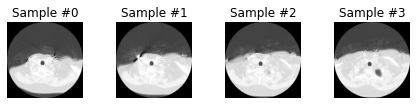

In [6]:
## plot training example
for i in range(len(covid_dataset_train_val)):
    sample = covid_dataset_train_val[i]
    print(i, sample['image'].shape, sample['percentage'], sample['subject'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

0 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0302.png
1 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0303.png
2 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0301.png
3 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0304.png


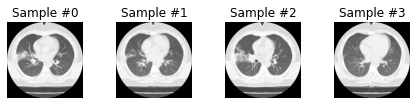

In [7]:
## plot test examples
for i in range(len(covid_dataset_test)):
    sample = covid_dataset_test[i]
    print(i, sample['image'].shape, sample['img_name'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

In [8]:
# generate the index of subjects for k-fold cross validation
def generate_index(dat,k):
    
    Y = list(range(0,dat[-1]['subject']+1))
    kf = KFold(n_splits=k, shuffle=True)
    n = len(Y)
    index = {'train_index':[],
             'val_index':[]}

    for train_index, val_index in kf.split(np.zeros(n), Y):
        index['train_index'].append(train_index)
        index['val_index'].append(val_index)
        
    
    return pd.DataFrame(index['train_index']).T,pd.DataFrame(index['val_index']).T

In [9]:
# get links form subjects to images
df = pd.read_csv('drive/MyDrive/DL_Project/Train.csv')
subtoimage = []
le = []
for sub in range(0,covid_dataset_train_val[-1]['subject']+1):
  subtoimage.append(df[df['0'] == sub].index.tolist())
  le.append(len(df[df['0'] == sub].index.tolist()))

In [10]:
# get images' index form subjects' index
def get_image_index(subindex,subtoimage):
    imageindex = []
    for sub in range(0,len(subindex)):
        imageindex.extend(subtoimage[subindex[sub]])
    return imageindex

In [ ]:
k = 4
train_index,val_index = generate_index(covid_dataset_train_val,k)
test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)
model_cv = []
valid_cvloss = []
for split_i in range(0,k):
  ## split given train set to train & val set by subjects
  train_imageindex = get_image_index(train_index.iloc[:,split_i],subtoimage)
  val_imageindex = get_image_index(val_index.iloc[:,split_i],subtoimage)
  train_dataset = torch.utils.data.Subset(covid_dataset_train_val,train_imageindex)
  val_dataset = torch.utils.data.Subset(covid_dataset_train_val,val_imageindex)
  train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
  val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)
 
  #Setting model and moving to device
  model_CNN = CNN1(True).to(device)

  criterion = nn.SmoothL1Loss()
  #optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
  optimizer = optim.Adam(model_CNN.parameters(), lr=0.0005)

  ## training model
  model_conv,valid_loss_min=train_model(model_CNN, criterion, optimizer)

  model_cv.append(model_conv)
  valid_cvloss.append(valid_loss_min)

Epoch 1, Batch 1 loss: 18.518366


In [12]:
## use imagenet pretrained model
## let's start with resnet34
!pip install pretrainedmodels

     |████████████████████████████████| 58 kB 2.9 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=487d3cc02e8933fef09990038f73b261433f249d9e35d8148ca9d36933a226c1
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
import pretrainedmodels
#For model building
import torch
from torch import nn, optim
import torchvision
from torch.nn import functional as F

class CNN1(nn.Module):
    def __init__(self, pretrained=True):
        super(CNN1, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(512, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        #print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label

In [15]:
#Setting model and moving to device
model_CNN = CNN1(True).to(device)

criterion = nn.SmoothL1Loss()
#optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [16]:
def train_model(model, criterion, optimizer, n_epochs=10):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    for epoch in range(1, n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        # train the model #
        model.train()
        for batch_idx, sample_batched in enumerate(train_dataloader):
            # importing data and moving to GPU
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            output=model(image).reshape(-1)
            # calculate loss
            loss = criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            # back prop
            loss.backward()
            # grad
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        # validate the model #
        model.eval()
        for batch_idx, sample_batched in enumerate(val_dataloader):
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)  
            output = model(image).reshape(-1)
            # calculate loss
            loss=criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model, 'drive/MyDrive/DL_Project/model.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
    # return trained model
    return model,valid_loss_min

In [17]:

model_conv,valid_loss_min=train_model(model_CNN, criterion, optimizer)

Epoch 1, Batch 1 loss: 25.290535
Epoch 1, Batch 101 loss: 14.717875
Epoch 1, Batch 201 loss: 13.844293


KeyboardInterrupt: ignored

In [ ]:
df = pd.DataFrame(columns=['image_name','output'])
for batch_idx, sample_batched in enumerate(test_dataloader):
    image= sample_batched['image'].to(device)
    img_name= sample_batched['img_name']
    output = model_conv(image).type(torch.LongTensor).reshape(-1)
    img_name = np.array(img_name).reshape(output.shape[0],1)
    o = output.cpu().data.numpy().reshape(output.shape[0],1)
    a = np.concatenate((img_name,o),axis=1)
    df = df.append(pd.DataFrame(a, columns=df.columns), ignore_index=True)

NameError: ignored

In [ ]:
#Extracting image name from the image path
df['image_name']=df['image_name'].str.split("/").str[-1]

In [ ]:
df.to_csv('drive/MyDrive/DL_Project/predictions.csv', index=False, header=False)

In [ ]:
df.head()